# Generation 3 Butler notes using S3 
***

## Contents
* **[Useful links](#Useful-links)**
* **[butler Command line tasks](#butlercmd)**
    * [Creating a generation 3 butler repository](#Gen3repo)
    * [Adding an instrument to the GEN 3 butler repository](#Addinstr)
    * [Ingest raw frames into from a directory into the butler registry](#ingest_raws)
    * [Importing data accross two GEN 3 repositories](#importing)
    * [Convert a Butler gen 2 repository into a gen 3 repository](#Converttogen3)

* **[Butler using a jupyter notebook](#butjup)**
    * [LSST Stack Imports](#imports)
    * [Accessing the butler repository](#accessbut)
    * [Accessing the data registry](#datareg)
    * [Plotting](#plotting)
    * [Getting the URIs](#uri)
    * [Exporting](#exporting)
    * [Importing](#importingjup)
***
    


## Useful links <a class="anchor" id="Useful-links"></a>
- https://pipelines.lsst.io/modules/lsst.daf.butler/scripts/butler.py.html
- https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Gen3ButlerTutorial.ipynb
- https://dmtn-073.lsst.io/
- https://stackclub.readthedocs.io/en/latest/notebooks.html#getting-started
- https://docushare.lsstcorp.org/docushare/dsweb/Get/presentation-890/Gen3%20Middleware.pdf
- https://pipelines.lsst.io/modules/lsst.ap.pipe/getting-started.html?highlight=gen
- https://pipelines.lsst.io/search.html?q=gen+3&check_keywords=yes&area=default
- https://pipelines.lsst.io/v/weekly/py-api/lsst.daf.butler.Butler.html
- https://github.com/LSSTScienceCollaborations/StackClub
- https://notebook.community/hsinfang/lsst-notes/gen3butler/gen3notes
- https://github.com/lsst/testdata_jointcal/tree/master/scripts
***



## butler Command line tasks  <a class="anchor" id="butlercmd"></a>
***

### butler Commands help 

In [1]:
! butler --help

Usage: butler [OPTIONS] COMMAND [ARGS]...

Options:
  --log-level LEVEL|COMPONENT=LEVEL ...
                                  The logging level. Supported levels are
                                  [CRITICAL|ERROR|WARNING|INFO|DEBUG]
  --long-log                      Make log messages appear in long format.
  -h, --help                      Show this message and exit.

Commands:
  certify-calibrations        Certify calibrations in a repository.
  config-dump                 Dump butler config to stdout.
  config-validate             Validate the configuration files.
  convert                     Convert a gen2 repo to gen3.
  create                      Create an empty Gen3 Butler repository.
  define-visits               Define visits from exposures.
  import                      Import data into a butler repository.
  ingest-raws                 Ingest raw frames.
  make-discrete-skymap        Define a discrete skymap from calibrated
                              exposures.
  prun

###  Creating a generation 3 butler repository <a class="anchor" id="Gen3repo"></a>
***

In [2]:
! butler create --help

Usage: butler create [OPTIONS] REPO

  Create an empty Gen3 Butler repository.

  REPO is the URI or path to the new repository. Will be created if it does
  not exist.

Options:
  --seed-config TEXT       Path to an existing YAML config file to apply (on
                           top of defaults).
  --dimension-config TEXT  Path to an existing YAML config file with dimension
                           configuration.
  --standalone             Include all defaults in the config file in the
                           repo, insulating the repo from changes in package
                           defaults.
  --override               Allow values in the supplied config to override all
                           repo settings.
  -f, --outfile TEXT       Name of output file to receive repository
                           configuration. Default is to write butler.yaml into
                           the specified repo.
  -@, --options-file TEXT  URI to YAML file containing overrides of comman

***
- Step 1 : Creating  registry file (reg.yaml file) <br><br>
    
    - Firstly, we need to create a SQL file for the registry (e.g vi test.sqlite3) (postgresql is often use for S3) <br><br>
    
    - Then, we have to create an S3 bucket on echo which will be the butler repository. I used Rclone
  (https://rclone.org/docs/) to do this "rclone mkdir remote:bucket_name"<br><br>
    
    - Now we have all of this, create a new file and call it reg.yaml. Within that file you have the path to the SQL file. Example <br><br>
    
        - **registry**:<br>
                db: sqlite:////home/test.sqlite3 
	
            
- Step 2 : Configuring the butler repository <br><br>

	- Now we have got the butler.yaml file we can create an empty Gen3 Butler repository. <br><br>
	
	- We do this by using "butler create" which is a command line task 
	  (https://pipelines.lsst.io/modules/lsst.daf.butler/scripts/butler.py.html) <br><br>
	
	- We run: <br><br> 
        - **» butler create s3://bucket_name --seed-config reg.yaml --override** <br><br>
        - where s3://bucket_name is the REPO which is the URI or path to the new repository <br><br>
	
	- Now we have created a generation 3 Butler repository, if we check our s3 butler repository will see that
	  the butler.yaml is now in the repository. We can also check the sql file and see all the tables loaded in which help query the dataset<br><br>
***  

### Adding an instrument to the GEN 3 butler repository <a class="anchor" id="Addinstr"></a>

***

In [3]:
! butler register-instrument --help

Usage: butler register-instrument [OPTIONS] REPO INSTRUMENT ...

  Add an instrument to the data repository.

  REPO is the URI or path to the gen3 repository. Will be created if it does
  not already exist

  The fully-qualified name of an Instrument subclass.

Options:
  -h, --help  Show this message and exit.


***
- Step 1: Find the instrument class <br><br>
    - For lsst use this link (https://pipelines.lsst.io/modules/lsst.obs.lsst/index.html,
	  Ctrl-F lsst.obs.lsst Package) an example of class is "lsst.obs.lsst.LsstComCam" <br><br>

- Step 2: Running the "register-instrument" Command <br><br>
    - **» butler register-instrument s3://bucket_name lsst.obs.subaru.HyperSuprimeCam** <br><br>
    
    - where s3://bucket_name is the REPO which is the URI or path to the new repository and lsst.obs.subaru.HyperSuprimeCam is the instrument class <br><br>
    
- **Note** that for butler subcommands once an instrument is registered you can refer to that instrument by the short name <br>(e.g. » **butler write-curated-calibrations s3://bucket_name <u>HSC</u>** ) 
***

### Ingest raw frames into from a directory into the butler registry <a class="anchor" id="ingest_raws"></a>

***

In [4]:
! butler ingest-raws --help

Usage: butler ingest-raws [OPTIONS] REPO LOCATIONS ...

  Ingest raw frames into from a directory into the butler registry

  REPO is the URI or path to the gen3 repository. Will be created if it does
  not already exist

  LOCATIONS specifies files to ingest and/or locations to search for files.

Options:
  --regex TEXT                    Regex string used to find files in
                                  directories listed in LOCATIONS. Searches
                                  for fits files by default.
  -c, --config TEXT=TEXT ...      Config override, as a key-value pair.
  -C, --config-file FILE          Path to a pex config override to be included
                                  after the Instrument config overrides are
                                  applied.
  --output-run TEXT               The name of the run datasets should be
                                  output to.
  -t, --transfer [auto|link|symlink|hardlink|copy|move|relsymlink]
                               

***
- Step 1: Adding an instrument to the GEN 3 butler repository <br><br>

	- Make sure that an instrument has been added the into the GEN 3 butler repository (Look the above for instructions to how to add an instrument to the butler repsitory) <br><br>

- Step 2:  Running the "ingest-raws" Command <br><br>

	- **» butler ingest-raws s3://bucket_name /home/lsst_stack/testdata_ci_hsc/raw** <br><br>
    
    - where s3://bucket_name is the REPO which is the URI or path to the new repository and /home/lsst_stack/testdata_ci_hsc/raw is the LOCATIONs specifies files to ingest and/or locations to search for files.
***

### Convert a Butler gen 2 repository into a gen 3 repository <a class="anchor" id="Converttogen3"></a>



In [5]:
! butler convert --help

Usage: butler convert [OPTIONS] REPO

  Convert a Butler gen 2 repository into a gen 3 repository.

  REPO is the URI or path to the gen3 repository. Will be created if it does
  not already exist

Options:
  --gen2root TEXT                 Root path of the gen 2 repo to be converted.
                                  [required]
  --skymap-name TEXT              Name of the new gen3 skymap (e.g.
                                  'discrete/ci_hsc').
  --skymap-config TEXT            Path to skymap config file defining the new
                                  gen3 skymap.
  --calibs TEXT                   Path to the gen 2 calibration repo. It can
                                  be absolute or relative to gen2root.
  --reruns TEXT ...               List of gen 2 reruns to convert.
  -t, --transfer [auto|link|symlink|hardlink|copy|move|relsymlink]
                                  Mode to use to transfer files into the new
                                  repository.
  -j, --processes

***
- Step 1: Set up a Gen 3 butler repository(Look above for instructions) <br><br>

- Step 2:  Running the "convert" Command <br><br>

    - **» butler convert s3://bucket_name  --gen2root ~/lsst_stack/DATA --processes 2 --reruns "rerun/coadd,rerun/coaddPhot,rerun/processCcdOutputs,rerun/coaddForcedPhot" --calibs ~/lsst_stack/DATA/CALIB/** <br><br>
     - where s3://bucket_name is the REPO which is the URI or path to the new repository, --gen2root is the root path of the gen 2 repo to be converted and/home/lsst_stack/DATA is the path to the gen 2 repo, --processes sets the amount of proccessing cores use in the conversion, --reruns is the path to the rerun directories and --calibs is the path to the calib directory.<br><br>
	
	- The tutorial for create a gen 2 repository is here https://pipelines.lsst.io/getting-started/data-setup.html <br><br>
***

### Importing data accross two GEN 3 repositories <a class="anchor" id="importing"></a>


***

In [6]:
! butler import --help

Usage: butler import [OPTIONS] REPO DIRECTORY

  Import data into a butler repository.

  REPO is the URI or path to the new repository. Will be created if it does
  not exist.

  DIRECTORY is the folder containing dataset files.

Options:
  -t, --transfer [auto|link|symlink|hardlink|copy|move|relsymlink]
                                  The external data transfer mode.
  --export-file FILENAME          Name for the file that contains database
                                  information associated with the exported
                                  datasets.  If this is not an absolute path,
                                  does not exist in the current working
                                  directory, and --dir is provided, it is
                                  assumed to be in that directory.  Defaults
                                  to "export.yaml".
  -s, --skip-dimensions TEXT ...  Dimensions that should be skipped during
                                  import
  -@, -

***
- Step 1: Export the data <br><br>
    - Firstly you will have export data from the repository with the data currently in it.([how to export data](#exporting)) <br><br>

- Step 2: Running the "import" Command <br><br>
    - **»  butler import s3://bucket_name_new s3://bucket_name --export-file exports.yaml**<br><br>
    - where s3://bucket_name is the REPO which is the URI or path to the repository with the data and s3://bucket_name_new is the REPO which is the URI or path to the repository ehre you want to put your data .
***

## Butler using a jupyter notebook  <a class="anchor" id="butjup"></a>
***

 ### LSST Stack Imports <a class="anchor" id="imports"></a>
 
 - butler class (https://pipelines.lsst.io/v/weekly/py-api/lsst.daf.butler.Butler.html) <br>
 - Image display class(https://pipelines.lsst.io/v/weekly/modules/lsst.afw.display/index.html) <br>
 - pylab for plotting <br>

In [1]:
import lsst.daf.butler as Butler
import lsst.afw.display as afwDisplay
import pylab as plt
import os,glob
import lsst.geom as geom

***
### Accessing the butler repository  <a class="anchor" id="accessbut"></a>

In [9]:
butler = Butler.Butler("s3://joshuakitenge-DATA-ed")

***
### Accessing the data registry   <a class="anchor" id="datareg"></a>

In [10]:
registry = butler.registry


The registry is a good tool for investigating a repo (more on the registry schema can be found here). For example, we can get a list of all collections, which includes the HSC/raw/all collection that we were using before

In [11]:
for c in registry.queryCollections():
    print(c)

HSC/raw/all
HSC/calib
HSC/calib/unbounded
HSC/calib/curated/1970-01-01T00:00:00
HSC/calib/curated/2013-01-31T00:00:00
HSC/calib/curated/2014-04-03T00:00:00
HSC/calib/curated/2014-06-01T00:00:00
HSC/calib/curated/2015-11-06T00:00:00
HSC/calib/curated/2016-04-01T00:00:00
HSC/calib/curated/2016-11-22T00:00:00
HSC/calib/curated/2016-12-23T00:00:00
refcats
HSC/calib/gen2/2014-11-12
HSC/calib/gen2/2014-07-14
HSC/calib/gen2/2013-11-03
HSC/calib/gen2/2013-06-17
shared/HSC/rerun/coadd
shared/HSC/rerun/coaddPhot
shared/HSC/rerun/processCcdOutputs
shared/HSC/rerun/coaddForcedPhot
shared/HSC


now that we "know" that HSC/raw/all exists, let's create our butler with this collection:

In [12]:
butler = Butler.Butler("s3://joshuakitenge-DATA-ed",collections='shared/HSC/rerun/processCcdOutputs')
registry = butler.registry

We can also use the registry to get a list of all dataset types

In [13]:
for x in registry.queryDatasetTypes():
    print(x)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
DatasetType('bfKernel', {instrument}, NumpyArray, isCalibration=True)
DatasetType('transmission_optics', {instrument}, TransmissionCurve, isCalibration=True)
DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True)
DatasetType('transmission_filter', {band, instrument, physical_filter}, TransmissionCurve, isCalibration=True)
DatasetType('transmission_atmosphere', {instrument}, TransmissionCurve, isCalibration=True)
DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog)
DatasetType('sky', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetTy

We suspect that this is all datasetTypes that the processing has tried to create during the processing. There may be intermediate products that were created during processing, but no longer exist.<br>

It is now possible to get all DatasetRef (including dataId) for a specific datasetType in a specific collection with a query like the one that follows

In [14]:
datasetRefs = list(registry.queryDatasets(datasetType='calexp',collections=['shared/HSC/rerun/processCcdOutputs']))
for ref_calexp in datasetRefs:
    print(ref_calexp.dataId)

{band: i, instrument: HSC, detector: 1, physical_filter: HSC-I, visit_system: 0, visit: 904014}
{band: i, instrument: HSC, detector: 12, physical_filter: HSC-I, visit_system: 0, visit: 904014}
{band: i, instrument: HSC, detector: 10, physical_filter: HSC-I, visit_system: 0, visit: 904010}
{band: i, instrument: HSC, detector: 25, physical_filter: HSC-I, visit_system: 0, visit: 903990}
{band: i, instrument: HSC, detector: 23, physical_filter: HSC-I, visit_system: 0, visit: 903988}
{band: i, instrument: HSC, detector: 18, physical_filter: HSC-I, visit_system: 0, visit: 903990}
{band: i, instrument: HSC, detector: 6, physical_filter: HSC-I, visit_system: 0, visit: 904014}
{band: i, instrument: HSC, detector: 100, physical_filter: HSC-I, visit_system: 0, visit: 903986}
{band: i, instrument: HSC, detector: 16, physical_filter: HSC-I, visit_system: 0, visit: 903986}
{band: i, instrument: HSC, detector: 24, physical_filter: HSC-I, visit_system: 0, visit: 903988}
{band: i, instrument: HSC, dete

Ok, now that we know what collections exist (HSC/raw/all in particular), the datasetTypes that are defined for that collection, and the datasetRefs (which contain dataIds) for data products of the requested type. This is all the information that we need to get the dataset of interest.

From the list above, I choose index 16 and with this we will find the dataId 

In [15]:
ref_calexp = datasetRefs[16]
print(ref_calexp.dataId)

{band: r, instrument: HSC, detector: 6, physical_filter: HSC-R, visit_system: 0, visit: 903346}


DatasetRef is a combination of dataset type and dataId and can refer to an explicit dataset in a specific run (if ref.dataId is defined)

In [17]:
print(ref_calexp)
print(ref_calexp.dataId)
print(ref_calexp.datasetType)

calexp@{band: r, instrument: HSC, detector: 6, physical_filter: HSC-R, visit_system: 0, visit: 903346}, sc=ExposureF] (id=1647)
{band: r, instrument: HSC, detector: 6, physical_filter: HSC-R, visit_system: 0, visit: 903346}
DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF)


***
### Plotting   <a class="anchor" id="plotting"></a>

- Using the dataset from above we can get the image (more on plotting in <br> https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Gen3ButlerTutorial.ipynb <br> https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb) <br>
- **getDirect(ref: 'DatasetRef',
    *,
    parameters: 'Optional[Dict[str, Any]]' = None,)** :	Retrieve a stored dataset.Unlike `Butler.get`, this method allows datasets outside the Butler'scollection to be read as long as the `DatasetRef` that identifies them can be obtained separately.<br>
- **get(  datasetRefOrType: 'Union[DatasetRef, DatasetType, str]',
    dataId: 'Optional[DataId]' = None,
    *,
    parameters: 'Optional[Dict[str, Any]]' = None,
    collections: 'Any' = None,)** : Retrieve a stored dataset.

In [24]:
# To get the image,we pass the dataId
calexp = butler.getDirect(ref_calexp)

(-0.5, 2047.5, -0.5, 4175.5)

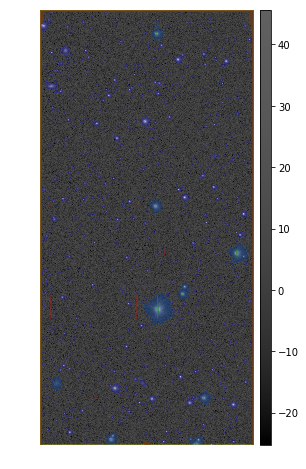

In [19]:
#And plot!
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
plt.gca().axis('off')


How to create a table using the data 

In [20]:
src = butler.get("src",dataId=ref_calexp.dataId)
src = src.copy(True)
src.asAstropy()

<Table length=1397>
        id              coord_ra      ... calib_photometry_reserved
                          rad         ...                          
      int64             float64       ...            bool          
------------------ ------------------ ... -------------------------
775968331164286977  5.598239588878948 ...                     False
775968331164286978  5.598243735742212 ...                     False
775968331164286979   5.59823976754709 ...                     False
775968331164286980  5.598239774246505 ...                     False
775968331164286981 5.5982398287034085 ...                     False
775968331164286982  5.598248397936587 ...                     False
775968331164286983  5.598246158852938 ...                     False
775968331164286984  5.598258914434359 ...                     False
775968331164286985  5.598261338979812 ...                     False
               ...                ... ...                       ...
775968331164288364  5.601478080556699 ...                     False
775968331164288365  5.601479558298078 ...                     False
775968331164288366  5.601490544599555 ...                     False
775968331164288367  5.601473425394161 ...                     False
775968331164288368   5.60150177121434 ...                     False
775968331164288369  5.601501654881336 ...                     False
775968331164288370  5.601559665691128 ...                     False
775968331164288371  5.601562042757234 ...                     False
775968331164288372  5.601555093320311 ...                     False
775968331164288373 5.6015511554439374 ...                     False

### More plotting 

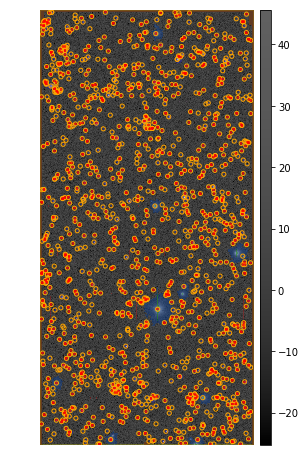

In [21]:
# And plot!
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp)
plt.gca().axis('off')

with afw_display.Buffering():
    for s in src:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange')

***
### Getting the URIs <a class="anchor" id="uri"></a>


- Getting the URI of the raw data <br>
- **getURI(datasetRefOrType, …)**:	Return the URI to the Dataset <br>
- **getURIs(datasetRefOrType, …)**:	Returns the URIs associated with the dataset <br>
- **getURIs** is the “proper” interface for retrieving URIs to a single dataset because butler supports composite disassembly. This means that you can configure your datastore such that on butler.put() it splits the dataset into its component parts. This means that for an Exposure it would write the image, variance, mask, wcs etc into separate files. The motivation for this is that you can then do butler.get("calexp.wcs",...) and for S3 that will be much much more efficient when disassembled since it will only download the small WCS file and not the entire file so that it can read a small part of it. In general composite disassembly is not the default but you can make it so by putting the relevant line in your seed yaml in the datastore section.<br> 
- **getURI** is there for the simple case and will break for you as soon as disassembly is turned on. raws are never disassembled so that’s always safe. If you have disassembled the getURIs dict will be filled in with keys like wcs mapping to a URI. getURIs returns the same answer as getURI in its first return value. 

In [18]:
Raw_URI=[]
Raw_URIs=[]
for ref in butler.registry.queryDatasets("calexp", collections=['shared/HSC/rerun/processCcdOutputs']):#, where="detector = 22"):
    uri = butler.getURI(ref)
    Raw_URI.append(uri)
    print("{}\n".format(uri))
   
    
#for ref in butler.registry.queryDatasets("raw", collections=['HSC/raw/all']):#, where="detector = 22"):
    #uri = butler.getURIs(ref)
    #print("{}\n".format(uri))
          
#print("{}\n".format(Raw_URI))
#print("{}\n".format(Raw_URIs))

s3://joshuakitenge-DATA-ed/shared/HSC/rerun/processCcdOutputs/calexp/i/HSC-I/904014/calexp_i_HSC-I_904014_1_HSC_shared_HSC_rerun_processCcdOutputs.fits

s3://joshuakitenge-DATA-ed/shared/HSC/rerun/processCcdOutputs/calexp/i/HSC-I/904014/calexp_i_HSC-I_904014_12_HSC_shared_HSC_rerun_processCcdOutputs.fits

s3://joshuakitenge-DATA-ed/shared/HSC/rerun/processCcdOutputs/calexp/i/HSC-I/904010/calexp_i_HSC-I_904010_10_HSC_shared_HSC_rerun_processCcdOutputs.fits

s3://joshuakitenge-DATA-ed/shared/HSC/rerun/processCcdOutputs/calexp/i/HSC-I/903990/calexp_i_HSC-I_903990_25_HSC_shared_HSC_rerun_processCcdOutputs.fits

s3://joshuakitenge-DATA-ed/shared/HSC/rerun/processCcdOutputs/calexp/i/HSC-I/903988/calexp_i_HSC-I_903988_23_HSC_shared_HSC_rerun_processCcdOutputs.fits

s3://joshuakitenge-DATA-ed/shared/HSC/rerun/processCcdOutputs/calexp/i/HSC-I/903990/calexp_i_HSC-I_903990_18_HSC_shared_HSC_rerun_processCcdOutputs.fits

s3://joshuakitenge-DATA-ed/shared/HSC/rerun/processCcdOutputs/calexp/i/HSC-I/

***
### Exporting  <a class="anchor" id="exporting"></a>

- useful link https://github.com/lsst/testdata_jointcal/blob/master/scripts/export_gen3_hsc.py
- Exporting the whole directory <br>
- To do this you'll need to know the Top level directory structure of all of the collections <br>
- If you only want to download a specific dataset you can do that as well by just keeping the specfic dataset in the butler export function <br> 

In [26]:
with butler.export(filename = "exports.yaml") as export:
    # Raw files 
    export.saveDatasets(butler.registry.queryDatasets("raw", collections=['HSC/raw/all']))
    
    # defects files
    
    for collection in ('HSC/calib/curated/1970-01-01T00:00:00', 'HSC/calib/curated/2013-01-31T00:00:00',
                            'HSC/calib/curated/2014-04-03T00:00:00', 'HSC/calib/curated/2014-06-01T00:00:00',
                            'HSC/calib/curated/2015-11-06T00:00:00', 'HSC/calib/curated/2016-04-01T00:00:00',
                            'HSC/calib/curated/2016-11-22T00:00:00','HSC/calib/curated/2016-12-23T00:00:00'):
        export.saveDatasets(registry.queryDatasets(datasetType='defects',collections=collection))
     
    # Calibrations
     
    for datasetTypeName in ('camera','bfKernal', 'transmission_optics', 'transmission_sensor',
                            'transmission_filter', 'transmission_atmosphere'):
        export.saveDatasets(butler.registry.queryDatasets(datasetTypeName, collections=['HSC/calib/unbounded']))    
    
    # Reference catalog
    
    export.saveDatasets(registry.queryDatasets(datasetType='ps1_pv3_3pi_20170110',collections=['refcats']))
    
    # Gen 2 calibrations 
    
    export.saveDatasets(registry.queryDatasets(datasetType='sky',collections=['HSC/calib/gen2/2014-11-12']))
    export.saveDatasets(registry.queryDatasets(datasetType='sky',collections=['HSC/calib/gen2/2014-07-14']))
    for datasetTypeName in ('dark', 'bias', 'flat'):
        export.saveDatasets(butler.registry.queryDatasets(datasetTypeName, collections=['HSC/calib/gen2/2013-11-03']))
    export.saveDatasets(registry.queryDatasets(datasetType='flat',collections=['HSC/calib/gen2/2013-06-17']))
    
    # Coadditions
    
    for datasetTypeName in ('deepCoadd', 'deepCoadd_directWarp', 'deepCoadd_nImage','deepCoadd_psfMatchedWarp',
                            'deepCoadd_skyMap','deep_compareWarpAssembleCoadd_metadata','deep_makeCoaddTempExp_config',
                            'deep_makeCoaddTempExp_metadata','deep_safeClipAssembleCoadd_config','packages'):
        export.saveDatasets(butler.registry.queryDatasets(datasetTypeName, collections=['shared/HSC/rerun/coadd']))
    
    # Forced coaddition photometry
    
    for datasetTypeName in ('deepCoadd_forced_config', 'deblendCoaddSources_metadata', 'deepCoadd_forced_src',
                            'deepCoadd_forced_src_schema','deepCoadd_skyMap','deepCoadd_skyMap','packages'):
        export.saveDatasets(butler.registry.queryDatasets(datasetTypeName, collections=['shared/HSC/rerun/coaddForcedPhot']))
    
    # Coaddition photometry 
    
    for datasetTypeName in ('deblendCoaddSources_config', 'deepCoadd_calexp', 'deepCoadd_deblendedModel_schema',
                            'deepCoadd_deblendedFlux_schema','deepCoadd_det_schema','deepCoadd_meas_schema',
                            'deepCoadd_peak_schema','deepCoadd_ref','deepCoadd_mergeDet_schema','deepCoadd_ref_schema',
                            'deblendCoaddSources_metadata','deepCoadd_measMatchFull','deepCoadd_skyMap','deepCoadd_mergeDet',
                            'detectCoaddSources_config','deepCoadd_measMatch','deepCoadd_calexp_background',
                            'deepCoadd_meas','deepCoadd_det','measureCoaddSources_config','deepCoadd_deblendedFlux',
                            'detectCoaddSources_metadata','mergeCoaddDetections_config','mergeCoaddMeasurements_config',
                            'packages','measureCoaddSources_metadata'):
        export.saveDatasets(butler.registry.queryDatasets(datasetTypeName, collections=['shared/HSC/rerun/coaddPhot']))
    
    # Process CCD outputs
    
    
    for datasetTypeName in ('icSrc_schema', 'packages', 'srcMatchFull',
                            'srcMatch','processCcd_config','src_schema',
                            'processCcd_metadata','calexpBackground','src','icSrc',
                            'calexp'):
        export.saveDatasets(butler.registry.queryDatasets(datasetTypeName, collections=['shared/HSC/rerun/processCcdOutputs']))
    


***
### Importing  <a class="anchor" id="importingjup"></a>
- Using either a preexisting GEN 3 butler repository or a a new GEN 3 butler repository <br>
- Set up the but client for the new repository and make sure that "writeable=True" is there <br>
- As I'm transfer the data from one repository to another I'll set ""transfer="auto" otherwise transfer has Options:auto, link , symlink , hardlink , copy , move , relsymlink and direct


In [ ]:
butler_im = Butler.Butler("s3://joshkite-data-up-test-ed",writeable=True)
butler_im.import_(directory="/home/vrs42921/lsst_stack/DATA_gen3",filename="exports.yaml",transfer="auto")

Check if the files transfered 

In [20]:
butler_im_test = dafButler.Butler("s3://joshkite-data-up-test-ed")
reg =butler_im_test.registry
for c in reg.queryCollections():
    print(c)


HSC/calib/curated/1970-01-01T00:00:00
HSC/calib/curated/2013-01-31T00:00:00
HSC/calib/curated/2014-04-03T00:00:00
HSC/calib/curated/2014-06-01T00:00:00
HSC/calib/curated/2015-11-06T00:00:00
HSC/calib/curated/2016-04-01T00:00:00
HSC/calib/curated/2016-11-22T00:00:00
HSC/calib/curated/2016-12-23T00:00:00
HSC/calib/gen2/2013-06-17
HSC/calib/gen2/2013-11-03
HSC/calib/gen2/2014-07-14
HSC/calib/gen2/2014-11-12
HSC/calib/unbounded
HSC/raw/all
refcats
shared/HSC/rerun/coadd
shared/HSC/rerun/coaddForcedPhot
shared/HSC/rerun/coaddPhot
shared/HSC/rerun/processCcdOutputs


In [21]:
datasetRefs_test = list(reg.queryDatasets(datasetType='raw',collections=['HSC/raw/all']))
for ref2 in datasetRefs_test:
    print(ref2.dataId)

{band: i, instrument: HSC, detector: 100, physical_filter: HSC-I, exposure: 903986}
{band: i, instrument: HSC, detector: 16, physical_filter: HSC-I, exposure: 903986}
{band: i, instrument: HSC, detector: 22, physical_filter: HSC-I, exposure: 903986}
{band: i, instrument: HSC, detector: 23, physical_filter: HSC-I, exposure: 903986}
{band: i, instrument: HSC, detector: 16, physical_filter: HSC-I, exposure: 903988}
{band: i, instrument: HSC, detector: 17, physical_filter: HSC-I, exposure: 903988}
{band: i, instrument: HSC, detector: 23, physical_filter: HSC-I, exposure: 903988}
{band: i, instrument: HSC, detector: 24, physical_filter: HSC-I, exposure: 903988}
{band: i, instrument: HSC, detector: 18, physical_filter: HSC-I, exposure: 903990}
{band: i, instrument: HSC, detector: 25, physical_filter: HSC-I, exposure: 903990}
{band: i, instrument: HSC, detector: 100, physical_filter: HSC-I, exposure: 904010}
{band: i, instrument: HSC, detector: 10, physical_filter: HSC-I, exposure: 904010}
{b